## 1. Instalação e Setup

In [1]:
# Instalação das bibliotecas necessárias
!pip install ultralytics opencv-python matplotlib --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importação das bibliotecas necessárias
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import requests

## 2. Carregando um modelo pré-treinado

In [3]:
# Carregando o modelo YOLOv8n (nano - versão mais leve)
model = YOLO('yolov8l.pt')

# Também podemos carregar diferentes tamanhos de modelo:
# model = YOLO('yolov8s.pt')  # small
# model = YOLO('yolov8m.pt')  # medium
# model = YOLO('yolov8l.pt')  # large
# model = YOLO('yolov8x.pt')  # extra large

100%|██████████| 83.7M/83.7M [00:18<00:00, 4.75MB/s]


## 3. Função auxiliar para visualização

In [4]:
def visualize_detection(image, results):
    """
    Visualiza a imagem com as detecções.
    """
    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(results[0].plot())
    plt.axis('off')
    plt.show()

    boxes = results[0].boxes
    print(f"Foram detectados {len(boxes)} objetos")

    for i, box in enumerate(boxes):
        cls = int(box.cls[0])
        name = model.names[cls]
        conf = float(box.conf[0])
        print(f"Detecção {i+1}: {name} com confiança {conf:.2f}")

## 4. Processamento automático de imagens e vídeos (apenas motos)



Processando imagem: ChatGPT Image 21 de mai. de 2025, 12_35_13.png

image 1/1 c:\Users\luizf\fiap-mottu-yolo-detection\ChatGPT Image 21 de mai. de 2025, 12_35_13.png: 640x640 8 motorcycles, 1086.2ms
Speed: 18.9ms preprocess, 1086.2ms inference, 16.6ms postprocess per image at shape (1, 3, 640, 640)


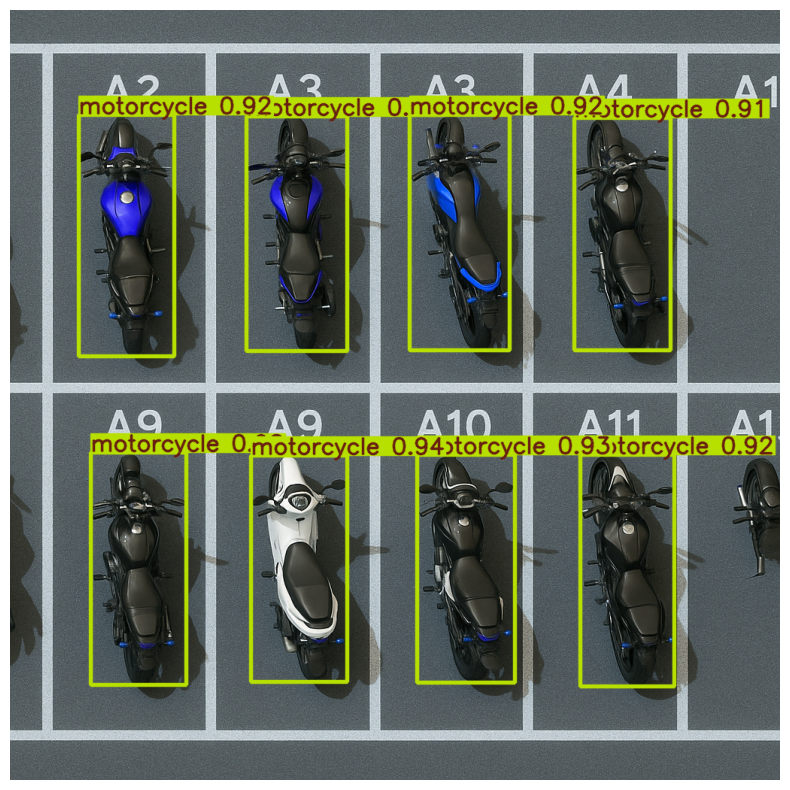

Foram detectados 8 objetos
Detecção 1: motorcycle com confiança 0.94
Detecção 2: motorcycle com confiança 0.93
Detecção 3: motorcycle com confiança 0.92
Detecção 4: motorcycle com confiança 0.92
Detecção 5: motorcycle com confiança 0.92
Detecção 6: motorcycle com confiança 0.92
Detecção 7: motorcycle com confiança 0.91
Detecção 8: motorcycle com confiança 0.91
Bounding boxes:
tensor([[320.0208, 592.8649, 448.5845, 893.2147],
        [541.1528, 591.2218, 671.0974, 894.5778],
        [ 91.4446, 139.5362, 218.9420, 460.0073],
        [531.1552, 139.9878, 664.8577, 452.5817],
        [107.7542, 588.8455, 234.4348, 897.5186],
        [758.4169, 591.4944, 883.6286, 899.6460],
        [314.3491, 141.1644, 448.2655, 453.5334],
        [750.3665, 143.9342, 878.2444, 452.5354]])

Classes detectadas:
tensor([3., 3., 3., 3., 3., 3., 3., 3.])

Nomes das classes:
motorcycle
motorcycle
motorcycle
motorcycle
motorcycle
motorcycle
motorcycle
motorcycle

Scores de confiança:
tensor([0.9399, 0.9318, 0.92

In [5]:
# Lista todos os arquivos da pasta raiz
arquivos = os.listdir('.')

# Filtra imagens e vídeos
imagens = [f for f in arquivos if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
videos = [f for f in arquivos if f.lower().endswith(('.mp4', '.avi', '.mov'))]

# Processa todas as imagens (apenas motos)
for img in imagens:
    print(f"\nProcessando imagem: {img}")
    results = model(
        img,
        conf=0.5,
        iou=0.7,
        max_det=20,
        classes=[3]
    )
    visualize_detection(img, results)

    # --- Imprime informações detalhadas das detecções ---
    result = results[0]
    print("Bounding boxes:")
    print(result.boxes.xyxy)

    print("\nClasses detectadas:")
    print(result.boxes.cls)

    print("\nNomes das classes:")
    for c in result.boxes.cls:
        print(model.names[int(c)])

    print("\nScores de confiança:")
    print(result.boxes.conf)

# Processa todos os vídeos (apenas motos)
for vid in videos:
    print(f"\nProcessando vídeo: {vid}")
    results_video = model(
        vid,
        save=True,
        conf=0.5,
        iou=0.7,
        max_det=20,
        classes=[3]
    )
    print(f"Vídeo processado salvo em 'runs/detect/predict/'")

##  7. Lista de classes COCO

In [16]:
# Lista de todas as classes que o modelo reconhece
for idx, class_name in model.names.items():
    print(f"{idx}: {class_name}")


0: person
1: bicycle
2: car
3: motorcycle
4: airplane
5: bus
6: train
7: truck
8: boat
9: traffic light
10: fire hydrant
11: stop sign
12: parking meter
13: bench
14: bird
15: cat
16: dog
17: horse
18: sheep
19: cow
20: elephant
21: bear
22: zebra
23: giraffe
24: backpack
25: umbrella
26: handbag
27: tie
28: suitcase
29: frisbee
30: skis
31: snowboard
32: sports ball
33: kite
34: baseball bat
35: baseball glove
36: skateboard
37: surfboard
38: tennis racket
39: bottle
40: wine glass
41: cup
42: fork
43: knife
44: spoon
45: bowl
46: banana
47: apple
48: sandwich
49: orange
50: broccoli
51: carrot
52: hot dog
53: pizza
54: donut
55: cake
56: chair
57: couch
58: potted plant
59: bed
60: dining table
61: toilet
62: tv
63: laptop
64: mouse
65: remote
66: keyboard
67: cell phone
68: microwave
69: oven
70: toaster
71: sink
72: refrigerator
73: book
74: clock
75: vase
76: scissors
77: teddy bear
78: hair drier
79: toothbrush
